# Preprocess data for machine learning

### March 3, 2018
### Tiffany Huang

In [121]:
%matplotlib inline
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV

# Input data files are available in the "WDataFiles/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "WDataFiles"]).decode("utf8"))

WCities.csv
WFieldGoalPercentage.csv
WFieldGoalPercentage_IDs.csv
WGameCities.csv
WNCAATourneyCompactResults.csv
WNCAATourneySeeds.csv
WNCAATourneySlots.csv
WReboundMargin.csv
WReboundMargin_IDs.csv
WRegularSeasonCompactResults.csv
WSampleSubmissionStage1.csv
WScoringMargin.csv
WScoringMargin_IDs.csv
WScoringOffense.csv
WScoringOffense_IDs.csv
WSeasons.csv
WTeamSpellings.csv
WTeams.csv
WTurnovers.csv
WTurnovers_IDs.csv
ranking_macro.xlsm



# Load the Training Data

In [133]:
data_dir = 'WDataFiles/'
df_seeds = pd.read_csv(data_dir + 'WNCAATourneySeeds.csv')
df_tourney = pd.read_csv(data_dir + 'WNCAATourneyCompactResults.csv')
df_reg_season = pd.read_csv(data_dir + 'WRegularSeasonCompactResults.csv')
df_field_goal = pd.read_csv(data_dir + 'WFieldGoalPercentage_IDs.csv')
df_rebounds = pd.read_csv(data_dir + 'WReboundMargin_IDs.csv')
df_scoring_margin = pd.read_csv(data_dir + 'WScoringMargin_IDs.csv')
df_scoring_offense = pd.read_csv(data_dir + 'WScoringOffense_IDs.csv')
df_turnovers = pd.read_csv(data_dir + 'WTurnovers_IDs.csv')

# Seeds Data

In [134]:
df_seeds.head()

,Season,Seed,TeamID
0,1998,W01,3330
1,1998,W02,3163
2,1998,W03,3112
3,1998,W04,3301
4,1998,W05,3272


In [135]:
# First, we'll simplify the datasets to remove the columns we won't be using 
# and convert the seedings to the needed format (stripping the regional abbreviation in front of the seed).

# Get just the digits from the seeding. Return as int
def seed_to_int(seed):
    s_int = int(seed[1:3])
    return s_int

df_seeds.drop(df_seeds[df_seeds.Season < 2002].index, inplace=True)
df_seeds.index = range(len(df_seeds))
df_seeds['seed_int'] = df_seeds.Seed.apply(seed_to_int)
df_seeds.drop(labels=['Seed'], inplace=True, axis=1) # This is the string label
df_seeds.head()

,Season,TeamID,seed_int
0,2002,3181,1
1,2002,3124,2
2,2002,3376,3
3,2002,3400,4
4,2002,3256,5


# Tournament Data

In [136]:
df_tourney.drop(labels=['DayNum', 'WScore', 'LScore', 'NumOT'], inplace=True, axis=1)
df_tourney.drop(df_tourney[df_tourney.Season < 2002].index, inplace=True)
df_tourney.index = range(len(df_tourney))
df_tourney.head()

,Season,WTeamID,LTeamID,WLoc
0,2002,3116,3155,H
1,2002,3124,3137,H
2,2002,3160,3380,H
3,2002,3179,3393,H
4,2002,3181,3313,H


In [137]:
# Merge the Seeds with their corresponding TeamIDs in the compact results dataframe.
df_winseeds = df_seeds.rename(columns={'TeamID':'WTeamID', 'seed_int':'WSeed'})
df_lossseeds = df_seeds.rename(columns={'TeamID':'LTeamID', 'seed_int':'LSeed'})
df_dummy = pd.merge(left=df_tourney, right=df_winseeds, how='left', on=['Season', 'WTeamID'])
df_concat = pd.merge(left=df_dummy, right=df_lossseeds, on=['Season', 'LTeamID'])
df_concat['SeedDiff'] = df_concat.WSeed - df_concat.LSeed
df_concat.drop(labels=['WSeed', 'LSeed'], inplace=True, axis=1)
df_concat.head()

,Season,WTeamID,LTeamID,WLoc,SeedDiff
0,2002,3116,3155,H,-5
1,2002,3124,3137,H,-13
2,2002,3160,3380,H,-11
3,2002,3179,3393,H,-3
4,2002,3181,3313,H,-15


# Regular Season Data

In [138]:
df_reg_season.drop(labels=['DayNum', 'WScore', 'LScore', 'WLoc', 'NumOT'], inplace=True, axis=1)
df_reg_season.drop(df_reg_season[df_reg_season.Season < 2002].index, inplace=True)
df_reg_season.index = range(len(df_reg_season))
df_reg_season.head()

,Season,WTeamID,LTeamID
0,2002,3160,3331
1,2002,3163,3193
2,2002,3191,3396
3,2002,3198,3372
4,2002,3307,3334


In [139]:
# Find the record during the regular season between two teams
def regSeasonToRecord(df):
    record_dict = {}
    for row in df.itertuples():
        if (row[1] not in record_dict):
            record_dict[row[1]] = {}
        else:
            if ((row[2], row[3]) in record_dict[row[1]]):
                record_dict[row[1]][(row[2], row[3])] += 1
            else:
                record_dict[row[1]][(row[2], row[3])] = 1
    return record_dict

record_dict = regSeasonToRecord(df_reg_season)

In [140]:
# Add the record between the winning and losing teams to the table
# Iterate through df_concat rows, look for record in dictionary between WTeam and LTeam and add it to the row
df_record = pd.DataFrame()
for row in df_concat.itertuples():
    if ((row[2], row[3]) in record_dict[row[1]]):
        df_record = df_record.append(pd.DataFrame([record_dict[row[1]][(row[2], row[3])]], columns=['Record']), ignore_index=True)
    elif ((row[3], row[2]) in record_dict[row[1]]):
        df_record = df_record.append(pd.DataFrame([-1.0 * record_dict[row[1]][(row[3], row[2])]], columns=['Record']), ignore_index=True)
    else:
        df_record = df_record.append(pd.DataFrame([0], columns=['Record']), ignore_index=True)
        
df_concat = pd.concat([df_concat, df_record], axis=1)
df_concat.head()

,Season,WTeamID,LTeamID,WLoc,SeedDiff,Record
0,2002,3116,3155,H,-5,0.0
1,2002,3124,3137,H,-13,0.0
2,2002,3160,3380,H,-11,0.0
3,2002,3179,3393,H,-3,0.0
4,2002,3181,3313,H,-15,0.0


# Field Goal Percentage Data

In [141]:
df_field_goal.drop(labels=['Team', 'Kaggle Name'], inplace=True, axis=1)
df_field_goal['FG Percentage'] = df_field_goal['FG Percentage'] / 100
df_field_goal['Kaggle TeamID'] = df_field_goal['Kaggle TeamID'].astype(int)
df_field_goal.head()

Season             int64
Ranking          float64
FG Percentage    float64
Kaggle TeamID      int64
dtype: object

In [142]:
df_win_fg = df_field_goal.rename(columns={'Kaggle TeamID':'WTeamID', 'FG Percentage':'WFGP'})
df_win_fg.head()
df_lose_fg = df_field_goal.rename(columns={'Kaggle TeamID':'LTeamID', 'FG Percentage':'LFGP'})
df_concat = pd.merge(left=df_concat, right=df_win_fg, how='inner', on=['Season', 'WTeamID'])
#df_concat = pd.merge(left=df_concat, right=df_lose_fg, how='right', on=['Season', 'LTeamID'])
df_concat

,Season,WTeamID,LTeamID,WLoc,SeedDiff,Record,Ranking,WFGP


,Season,WTeamID,LTeamID,WSeed,LSeed,SeedDiff,Record
0,1998,3104,3422,2,15,-13,0.0
1,1998,3112,3365,3,14,-11,0.0
2,1998,3163,3193,2,15,-13,2.0
3,1998,3198,3266,7,10,-3,-2.0
4,1998,3203,3208,10,7,3,1.0


In [13]:
# Now we'll create a dataframe that summarizes wins & losses along with 
# their corresponding seed differences. This is the meat of what we'll be creating our model on.
df_wins = pd.DataFrame()
df_wins['SeedDiff'] = df_concat['SeedDiff']
df_wins['Result'] = 1

df_losses = pd.DataFrame()
df_losses['SeedDiff'] = -df_concat['SeedDiff']
df_losses['Result'] = 0

df_predictions = pd.concat((df_wins, df_losses))
df_predictions.head()

,SeedDiff,Result
0,-13,1
1,-11,1
2,-13,1
3,-3,1
4,3,1


In [14]:
X_train = df_predictions.SeedDiff.values.reshape(-1,1)
y_train = df_predictions.Result.values
X_train, y_train = shuffle(X_train, y_train)

# Train the Model

In [15]:
# Use a basic logistic regression to train the model. You can set different C values to see how performance changes.
logreg = LogisticRegression()
params = {'C': np.logspace(start=-5, stop=3, num=9)}
clf = GridSearchCV(logreg, params, scoring='neg_log_loss', refit=True)
clf.fit(X_train, y_train)
print('Best log_loss: {:.4}, with best C: {}'.format(clf.best_score_, clf.best_params_['C']))

Best log_loss: -0.4569, with best C: 0.01


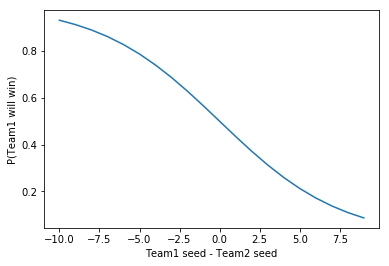

In [16]:
X = np.arange(-10, 10).reshape(-1, 1)
preds = clf.predict_proba(X)[:,1]

plt.figure()
plt.plot(X, preds)
plt.xlabel('Team1 seed - Team2 seed')
plt.ylabel('P(Team1 will win)')

In [18]:
df_sample_sub = pd.read_csv(data_dir + 'WSampleSubmissionStage1.csv')
n_test_games = len(df_sample_sub)
9yth
def get_year_t1_t2(ID):
    """Return a tuple with ints `year`, `team1` and `team2`."""
    return (int(x) for x in ID.split('_'))

In [19]:
X_test = np.zeros(shape=(n_test_games, 1))
for ii, row in df_sample_sub.iterrows():
    year, t1, t2 = get_year_t1_t2(row.ID)
    t1_seed = df_seeds[(df_seeds.TeamID == t1) & (df_seeds.Season == year)].seed_int.values[0]
    t2_seed = df_seeds[(df_seeds.TeamID == t2) & (df_seeds.Season == year)].seed_int.values[0]
    diff_seed = t1_seed - t2_seed
    X_test[ii, 0] = diff_seed

In [20]:
preds = clf.predict_proba(X_test)[:,1]

clipped_preds = np.clip(preds, 0.05, 0.95)
df_sample_sub.Pred = clipped_preds
df_sample_sub.head()

,ID,Pred
0,2014_3103_3107,0.628141
1,2014_3103_3113,0.259513
2,2014_3103_3119,0.500000
3,2014_3103_3124,0.052981
4,2014_3103_3140,0.434841


In [21]:
# Create submission file!
df_sample_sub.to_csv('logreg_seed_starter.csv', index=False)